In [1]:
from datetime import datetime
import json
import decimal
import io

import boto3
from boto3.dynamodb.conditions import Key, Attr

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [12]:
dynamodb = boto3.resource('dynamodb', region_name='ap-northeast-1')
table = dynamodb.Table('Enowind-DataTable-5FBP71OFI3IL')

today = datetime.now().strftime('%Y-%m-%d')
low = today + ' 00:00:00'
high = today + ' 23:59:59'

# response = table.query(
#     KeyConditionExpression=Key('timestamp').between(low, high)
# )

response = table.scan(
    FilterExpression=Key('timestamp').between(low, high)
)

data = []
for itm in response['Items']:
	dt = datetime.strptime(itm['timestamp'], '%Y-%m-%d %H:%M:%S')
	data.append([
        dt,
        float(itm['average_wind_speed']),
        float(itm['max_wind_speed']),
        float(itm['average_wind_direction'])
    ])

data.sort()

x = []
y = []
z = []
d = []
for r in data:
    x.append(r[0])
    y.append(r[1])
    z.append(r[2])
    d.append(r[3])

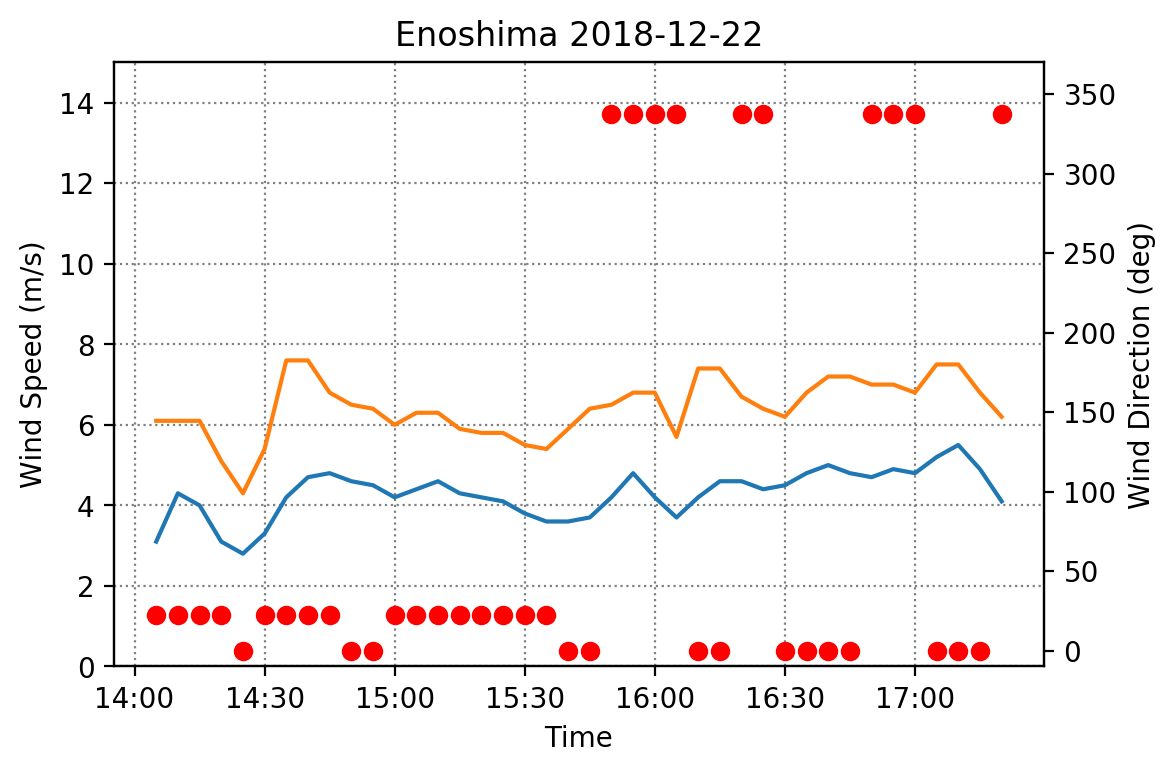

In [19]:
fig, ax1 = plt.subplots(figsize=(6, 4),dpi=200)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylim((0, 15))
plt.title('Enoshima ' + today)
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.grid(which='major',color='gray',linestyle=':')
ax1.plot(x, y)
ax1.plot(x, z)

ax2 = ax1.twinx()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylim((-10, 370))
plt.ylabel('Wind Direction (deg)')
ax2.plot(x, d, 'ro')

# plt.savefig('2018-12-22.png')

buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

with open('2018-12-22.png','wb') as f:
    f.write(buf.read()) 


In [24]:
buf.seek(0)
s3 = boto3.client('s3')
ret = s3.put_object(
    Body=buf.read(),
    Bucket='enowind.koheik.com',
    Key='figures/2018-12-22.png'
)